<a href="https://colab.research.google.com/github/MichaelPanikovskiy/d/blob/main/Task1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#ДЗ_1

In [29]:

!pip install requests beautifulsoup4 nltk wordcloud matplotlib


In [30]:
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
def get_article_links(page_count=2):
    links = []
    for page in range(1, page_count + 1):
        url = f'https://3dnews.ru/news/page-{page}.html'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')


        for article in soup.find_all('a', class_='entry-header'):
            link = article['href']
            if link.startswith('/'):
                link = 'https://3dnews.ru' + link
            links.append(link)
    return links


article_links = get_article_links(page_count=2)
print(f'Собрано {len(article_links)} ссылок на статьи.')


Собрано 200 ссылок на статьи.


In [32]:
def parse_article(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')


    title = soup.find('h1').get_text() if soup.find('h1') else 'N/A'
    date = soup.find('span', class_='article_date').get_text() if soup.find('span', class_='article_date') else 'N/A'
    views = soup.find('div', class_='views_count').get_text() if soup.find('div', class_='views_count') else 'N/A'
    text = ' '.join([p.get_text() for p in soup.find_all('p')])

    return {'title': title, 'date': date, 'views': views, 'text': text}


data = [parse_article(link) for link in article_links]
print(f'Собрано данных для {len(data)} статей.')


Собрано данных для 200 статей.


In [33]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(w.lower()) for w in words if w.isalnum() and w.lower() not in stop_words]
    return ' '.join(words)


for article in data:
    article['cleaned_text'] = preprocess_text(article['text'])

print("Очистка данных завершена.")


Очистка данных завершена.


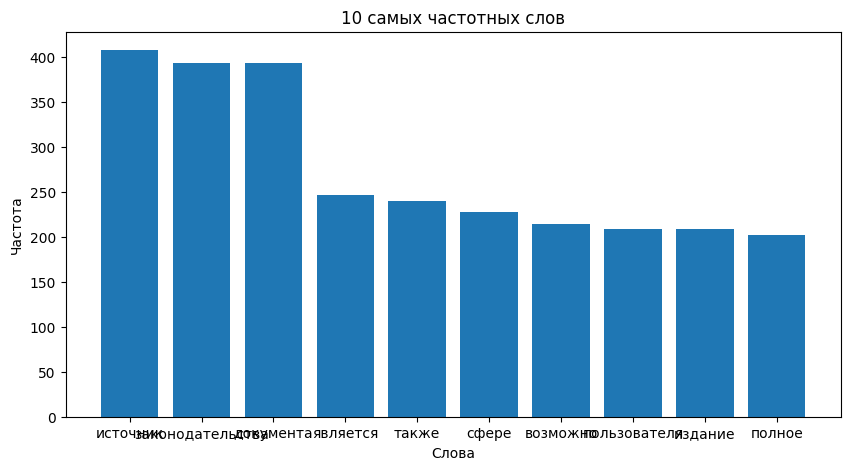

In [34]:

all_text = ' '.join(article['cleaned_text'] for article in data)
word_count = Counter(all_text.split())


common_words = word_count.most_common(10)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('10 самых частотных слов')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.show()


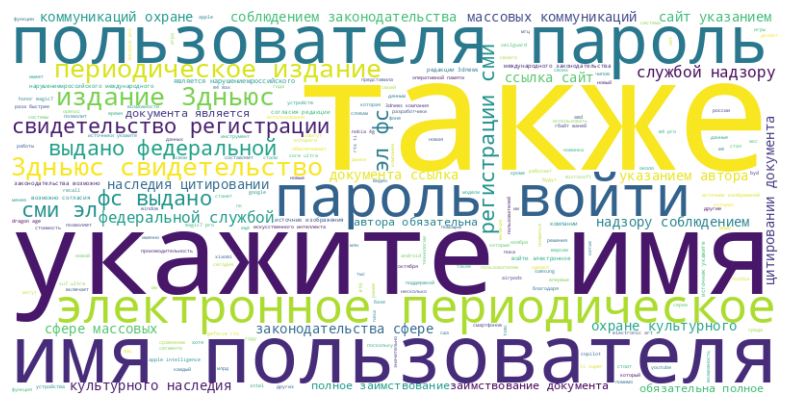

In [35]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


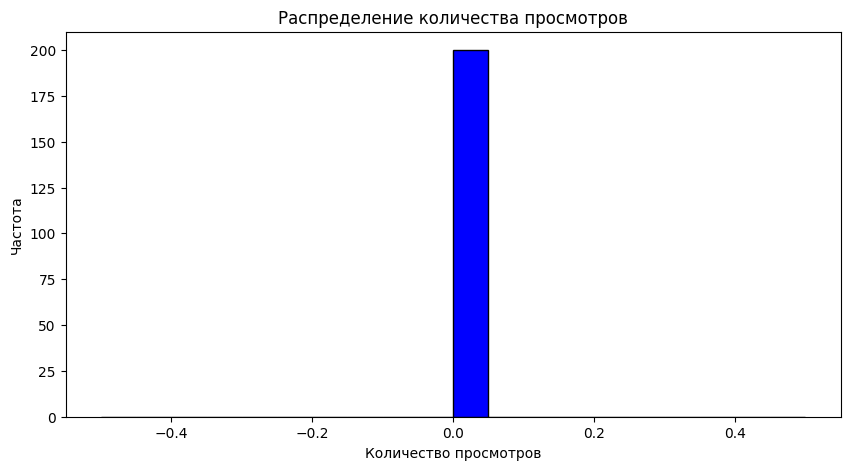

In [36]:
import pandas as pd


df = pd.DataFrame(data)


df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0)


plt.figure(figsize=(10, 5))
plt.hist(df['views'], bins=20, color='blue', edgecolor='black')
plt.title('Распределение количества просмотров')
plt.xlabel('Количество просмотров')
plt.ylabel('Частота')
plt.show()


In [37]:
#ДЗ_2

In [38]:
!pip install gensim scikit-learn nltk matplotlib


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:

data = pd.DataFrame(data)


tfidf_vectorizer = TfidfVectorizer(
    stop_words=list(stop_words),
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2),
    norm=None
)


tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])
print("Размер TF-IDF матрицы:", tfidf_matrix.shape)


Размер TF-IDF матрицы: (200, 1842)


In [41]:

tokenized_texts = [word_tokenize(text) for text in data['cleaned_text']]


w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, sg=1)


In [42]:

tfidf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

def vectorize_text_w2v(text, model, tfidf_weights):

    tokens = [word for word in word_tokenize(text) if word in model.wv and word in tfidf_weights]
    if not tokens:
        return np.zeros(model.vector_size)
    weighted_vectors = [model.wv[word] * tfidf_weights[word] for word in tokens]
    return np.mean(weighted_vectors, axis=0)


w2v_vectors = np.array([vectorize_text_w2v(text, w2v_model, tfidf_weights) for text in data['cleaned_text']])
print("Размер матрицы Word2Vec с весами TF-IDF:", w2v_vectors.shape)


Размер матрицы Word2Vec с весами TF-IDF: (200, 100)


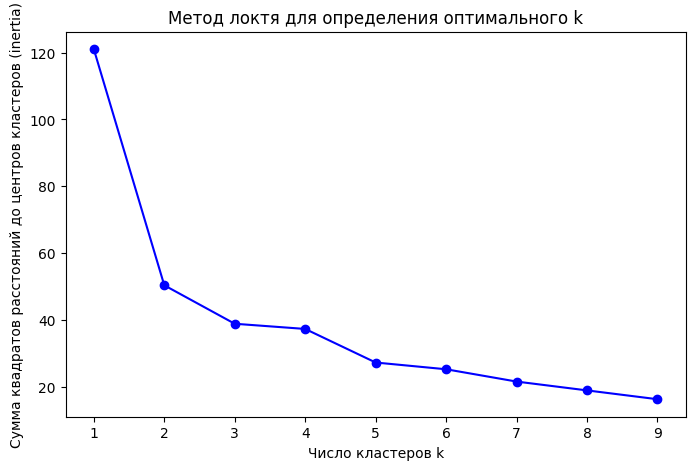

In [43]:
distortions = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(w2v_vectors)
    distortions.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Число кластеров k')
plt.ylabel('Сумма квадратов расстояний до центров кластеров (inertia)')
plt.title('Метод локтя для определения оптимального k')
plt.show()


In [44]:

k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
data['cluster'] = kmeans.fit_predict(w2v_vectors)


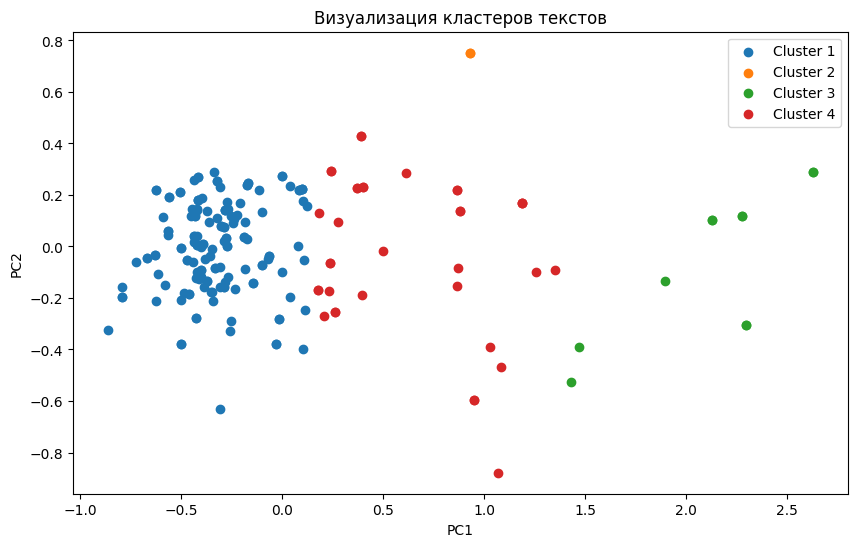

In [45]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(w2v_vectors)


plt.figure(figsize=(10, 6))
for i in range(k_optimal):
    cluster_points = reduced_vectors[data['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Визуализация кластеров текстов')
plt.legend()
plt.show()


In [46]:
#ДЗ_3

In [47]:
#ДЗ_4